##Importing libraries

In [1]:
import datetime
from math import ceil
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
telemetry_df = pd.read_csv('azure/PdM_telemetry.csv') #Reading telemetry data (Volt,rpm,pressure,vibration)
telemetry_df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [3]:
telemetry_df['datetime'].min(), telemetry_df['datetime'].max()

('2015-01-01 06:00:00', '2016-01-01 06:00:00')

In [4]:
telemetry_df['machineID'].value_counts()

machineID
1      8761
64     8761
74     8761
73     8761
72     8761
       ... 
31     8761
30     8761
29     8761
28     8761
100    8761
Name: count, Length: 100, dtype: int64

In [5]:
telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].describe()

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


In [6]:
telemetry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [7]:
failures = pd.read_csv('azure/PdM_failures.csv')
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [8]:
failures = failures.sort_values(by='datetime')
failures.reset_index(inplace=True, drop=True)
failures.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,56,comp3
1,2015-01-02 03:00:00,99,comp3
2,2015-01-02 03:00:00,83,comp4
3,2015-01-02 03:00:00,59,comp1
4,2015-01-02 03:00:00,16,comp1


In [9]:
failures['failure'].value_counts()

failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64

In [10]:
telemetry_with_failure_df = telemetry_df.merge(failures, on=['datetime', 'machineID'], how='left')
telemetry_with_failure_df.fillna('No Failure', inplace=True)

In [11]:
telemetry_with_failure_df['failure'].value_counts()

failure
No Failure    875381
comp2            259
comp1            192
comp4            179
comp3            131
Name: count, dtype: int64

In [12]:
machine_info = pd.read_csv('azure/PdM_machines.csv')
machine_info.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [13]:
telemetry_with_failure_df = machine_info.merge(right=telemetry_with_failure_df, on=['machineID'], how='left')
telemetry_with_failure_df.head(-10)

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure
...,...,...,...,...,...,...,...,...,...
876127,100,model4,5,2015-12-31 16:00:00,164.729171,448.894575,99.763131,43.916301,No Failure
876128,100,model4,5,2015-12-31 17:00:00,191.020128,537.789373,105.847232,45.791265,No Failure
876129,100,model4,5,2015-12-31 18:00:00,196.932834,360.053876,102.923230,30.398181,No Failure
876130,100,model4,5,2015-12-31 19:00:00,138.506098,497.861210,112.525039,34.867196,No Failure


In [14]:
telemetry_with_failure_df['model'].value_counts()

model
model3    306644
model4    280363
model2    148945
model1    140190
Name: count, dtype: int64

In [15]:
def strToDatetime(date_array, format):
    new_datetime = list()
    for date in date_array:
        new_datetime.append(datetime.datetime.strptime(date, format))
    return new_datetime

In [16]:
datetime_column = strToDatetime(telemetry_with_failure_df['datetime'], '%Y-%m-%d %H:%M:%S')

In [17]:
telemetry_with_failure_df['datetime'] = datetime_column

In [18]:
telemetry_with_failure_df['datetime'].min(), telemetry_with_failure_df['datetime'].max()

(Timestamp('2015-01-01 06:00:00'), Timestamp('2016-01-01 06:00:00'))

In [19]:
machine_ids = np.arange(1, 101)
len(machine_ids)

100

In [20]:
def hours_estimation(machine_id):
    df = telemetry_with_failure_df[telemetry_with_failure_df['machineID'] == machine_id]
    df.reset_index(drop=True, inplace=True)
    rul = []
    cont = len(df['failure']) - 1
    diff = 0
    while cont >= df.index.min():
        if df['failure'][cont] == 'No Failure':
            diff = diff + 1
            rul.append(diff)
        else:
            rul.append(0)
            diff = 0
        diff = rul[-1]
        cont = cont - 1
    df['hours_to_fail'] = list(reversed(rul))
    return df

In [21]:
dfs = []
for machine_id in machine_ids:
    df = hours_estimation(machine_id)
    dfs.append(df)

In [22]:
telemetry = pd.DataFrame()
for df in dfs:
    telemetry = pd.concat([telemetry, df], axis=0)

In [23]:
print(telemetry.shape[0], telemetry_with_failure_df.shape[0])

876142 876142


In [24]:
telemetry['seconds_to_fail'] = telemetry['hours_to_fail'] * 3600
telemetry.drop('hours_to_fail', axis=1, inplace=True)
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200


In [25]:
# sns.heatmap(telemetry.corr(), annot=True).figure.set_size_inches(12, 9)

In [26]:
telemetry.columns

Index(['machineID', 'model', 'age', 'datetime', 'volt', 'rotate', 'pressure',
       'vibration', 'failure', 'seconds_to_fail'],
      dtype='object')

In [27]:
datetimes = telemetry['datetime']
timestamps = list()
for datetime_ in datetimes:
    timestamps.append(datetime.datetime.timestamp(datetime_))    
datetimes.shape[0], len(timestamps)

(876142, 876142)

In [28]:
telemetry['timestamp'] = timestamps
#telemetry.drop('datetime', axis=1, inplace=True)
#telemetry = telemetry[['timestamp', 'machineID', 'model', 'age', 'volt', 'rotate', 'pressure', 'vibration', 'failure', 'seconds_to_fail']]
telemetry

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail,timestamp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600,1.420072e+09
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000,1.420076e+09
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400,1.420079e+09
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800,1.420083e+09
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200,1.420087e+09
...,...,...,...,...,...,...,...,...,...,...,...
8756,100,model4,5,2016-01-01 02:00:00,179.438162,395.222827,102.290715,50.771941,No Failure,18000,1.451594e+09
8757,100,model4,5,2016-01-01 03:00:00,189.617555,446.207972,98.180607,35.123072,No Failure,14400,1.451597e+09
8758,100,model4,5,2016-01-01 04:00:00,192.483414,447.816524,94.132837,48.314561,No Failure,10800,1.451601e+09
8759,100,model4,5,2016-01-01 05:00:00,165.475310,413.771670,104.081073,44.835259,No Failure,7200,1.451605e+09


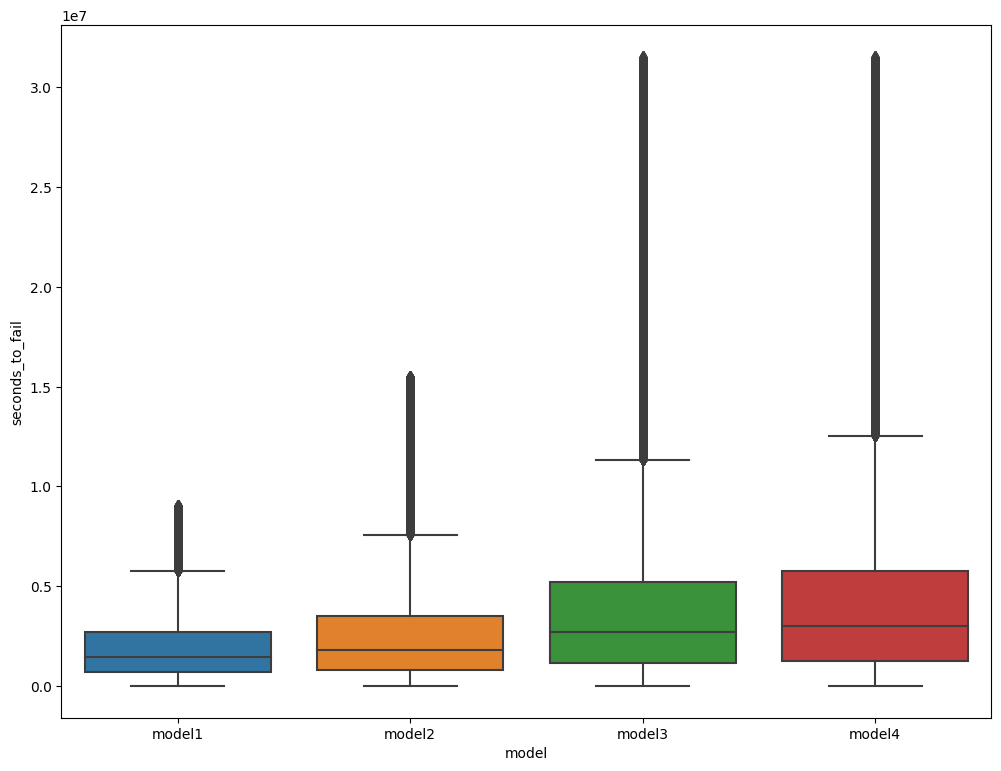

In [29]:
sns.boxplot(x=telemetry['model'], y=telemetry['seconds_to_fail'], order=['model1', 'model2', 'model3', 'model4']).figure.set_size_inches(12, 9)

In [30]:
telemetry['model'].value_counts()

model
model3    306644
model4    280363
model2    148945
model1    140190
Name: count, dtype: int64

##Make change for model here 

In [31]:
model3_data = telemetry[telemetry['model'] == 'model3'].reset_index(drop=True)
model3_data

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail,timestamp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600,1.420072e+09
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000,1.420076e+09
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400,1.420079e+09
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800,1.420083e+09
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200,1.420087e+09
...,...,...,...,...,...,...,...,...,...,...,...
306639,93,model3,18,2016-01-01 02:00:00,202.858467,412.870855,85.569847,47.701614,No Failure,18000,1.451594e+09
306640,93,model3,18,2016-01-01 03:00:00,171.364527,459.880473,94.316793,47.592136,No Failure,14400,1.451597e+09
306641,93,model3,18,2016-01-01 04:00:00,182.867119,491.584480,90.332643,58.592710,No Failure,10800,1.451601e+09
306642,93,model3,18,2016-01-01 05:00:00,166.943545,352.047138,82.068954,46.256361,No Failure,7200,1.451605e+09


In [32]:
def create_time_step(data, machine_id):
    machine_id_data = data[data['machineID'] == machine_id]
    time_step = np.arange(1, machine_id_data.shape[0]+1)
    machine_id_data['time_step'] = time_step
    return machine_id_data

In [33]:
machineIDs = model3_data['machineID'].unique()
dataframes_with_time_step = []
for machine_id in machineIDs:
    dataframes_with_time_step.append(create_time_step(model3_data, machine_id))
len(dataframes_with_time_step)

35

In [34]:
model3_data = pd.DataFrame()
for df in dataframes_with_time_step:
    model3_data = pd.concat([model3_data, df])

In [35]:
#model3_data = model3_data[['age', 'volt', 'rotate', 'pressure', 'vibration', 'seconds_to_fail']]
model3_data.drop(['model', 'failure', 'datetime', 'timestamp', 'machineID'], axis=1, inplace=True)
model3_data

,age,volt,rotate,pressure,vibration,seconds_to_fail,time_step
0,18,176.217853,418.504078,113.077935,45.087686,345600,1
1,18,162.879223,402.747490,95.460525,43.413973,342000,2
2,18,170.989902,527.349825,75.237905,34.178847,338400,3
3,18,162.462833,346.149335,109.248561,41.122144,334800,4
4,18,157.610021,435.376873,111.886648,25.990511,331200,5
...,...,...,...,...,...,...,...
306639,18,202.858467,412.870855,85.569847,47.701614,18000,8757
306640,18,171.364527,459.880473,94.316793,47.592136,14400,8758
306641,18,182.867119,491.584480,90.332643,58.592710,10800,8759
306642,18,166.943545,352.047138,82.068954,46.256361,7200,8760


In [36]:
scaler = MinMaxScaler()

normalized_telemetry = pd.DataFrame(data=scaler.fit_transform(model3_data), columns=model3_data.columns)
normalized_telemetry.head()

,age,volt,rotate,pressure,vibration,seconds_to_fail,time_step
0,0.894737,0.510638,0.469652,0.472451,0.476569,0.010958,0.000000
1,0.894737,0.421045,0.439431,0.337821,0.448935,0.010844,0.000114
2,0.894737,0.475523,0.678413,0.183282,0.296461,0.010729,0.000228
3,0.894737,0.418248,0.330878,0.443188,0.411097,0.010615,0.000342
4,0.894737,0.385652,0.502013,0.463348,0.161269,0.010501,0.000457


In [37]:
#Split in 80-20% without random
train_size = ceil(normalized_telemetry.shape[0] * 0.8)
test_size = ceil(normalized_telemetry.shape[0] * 0.2)
print(f'Train size: {train_size}')
print(f'Test size: {test_size}')

Train size: 245316
Test size: 61329


In [38]:
# scaler = MinMaxScaler()

# normalized_telemetry = pd.DataFrame(data=scaler.fit_transform(model3_data), columns=model3_data.columns)
# normalized_telemetry.head()

In [39]:
#Resetting index for split
train_set = normalized_telemetry[:train_size]

test_set = normalized_telemetry[train_size:].reset_index(drop=True)

train_set.shape, test_set.shape

((245316, 7), (61328, 7))

In [40]:
# train_size = ceil(normalized_telemetry.shape[0] * 0.7)
# test_and_val_size = ceil((normalized_telemetry.shape[0] * 0.3) / 2)
# print(f'Train size: {train_size}')
# print(f'Test and validation size: {test_and_val_size}')

In [41]:
X_train = train_set.drop('seconds_to_fail', axis=1)
X_train = np.array(X_train)
y_train = train_set['seconds_to_fail']
y_train = np.array(y_train)

X_test = test_set.drop('seconds_to_fail', axis=1)
X_test = np.array(X_test)
y_test = test_set['seconds_to_fail']
y_test = np.array(y_test)

# X_valid = val_set.drop('seconds_to_fail', axis=1)
# X_valid = np.array(X_valid)
# y_valid = val_set['seconds_to_fail']
# y_valid = np.array(y_valid)

In [42]:
def print_plot(y_test, predict):
  error = mean_absolute_error(y_test, predict)
  print(f'MAE:{error}')
  mse = mean_squared_error(y_test, predict)
  print(f'MSE:{mse}')
  X = np.arange(y_test.shape[0])
#   plt.plot(y_test, color='red')
  plt.scatter(X,y_test, color='red',s=1)
#   plt.plot(predict, color='blue')
  plt.scatter(X,predict, color='blue',s=1)
  plt.ylim([0, 0.7])
  plt.show()

In [43]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(245316, 6)
(61328, 6)
(245316,)
(61328,)


#Bidiectional LSTM

Epoch 1/10
7667/7667 [==============================] - 6s 702us/step - loss: 0.0163
Epoch 2/10
7667/7667 [==============================] - 5s 697us/step - loss: 0.0152
Epoch 3/10
7667/7667 [==============================] - 5s 705us/step - loss: 0.0148
Epoch 4/10
7667/7667 [==============================] - 5s 711us/step - loss: 0.0145
Epoch 5/10
7667/7667 [==============================] - 5s 707us/step - loss: 0.0143
Epoch 6/10
7667/7667 [==============================] - 5s 709us/step - loss: 0.0141
Epoch 7/10
7667/7667 [==============================] - 6s 719us/step - loss: 0.0139
Epoch 8/10
7667/7667 [==============================] - 5s 712us/step - loss: 0.0138
Epoch 9/10
7667/7667 [==============================] - 6s 723us/step - loss: 0.0137
Epoch 10/10
1917/1917 [==============================] - 1s 298us/step - loss: 0.0212
Mean Squared Error: 0.021201804280281067
1917/1917 [==============================] - 1s 285us/step
MAE:0.10309918338418256
MSE:0.021201805048703205


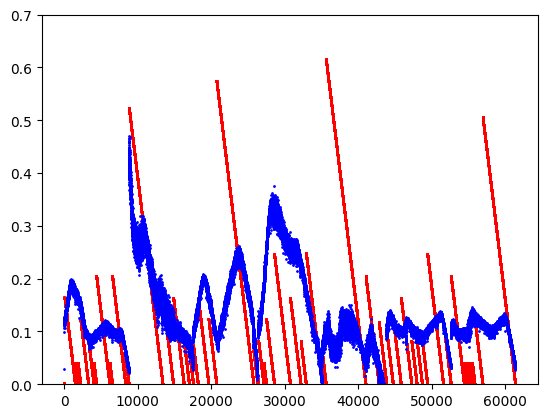

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from keras.layers import Add

#Data transfer
train_data = X_train  
train_labels = y_train 
test_data = X_test
test_labels = y_test

# Create the BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(None, 6)))
model.add(Dense(1))  # Output layer with a single neuron for forecasting

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Reshape the data for compatibility with BiLSTM input shape
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=32)

# # Evaluate the model
# mse = model.evaluate(test_data, test_labels)
# print(f"Mean Squared Error: {mse}")

# # Make predictions
# predictions = model.predict(test_data)
# Evaluate the model
mse = model.evaluate(test_data, test_labels)
print(f"Mean Squared Error: {mse}")

# Make predictions
predict = model.predict(test_data)
print_plot(y_test, predict)

#LSTM(RNN) with skip connection

Epoch 1/10
7667/7667 [==============================] - 6s 651us/step - loss: 0.0164
Epoch 2/10
7667/7667 [==============================] - 5s 689us/step - loss: 0.0150
Epoch 3/10
7667/7667 [==============================] - 5s 684us/step - loss: 0.0146
Epoch 4/10
7667/7667 [==============================] - 5s 658us/step - loss: 0.0144
Epoch 5/10
7667/7667 [==============================] - 5s 646us/step - loss: 0.0142
Epoch 6/10
7667/7667 [==============================] - 5s 685us/step - loss: 0.0141
Epoch 7/10
7667/7667 [==============================] - 5s 644us/step - loss: 0.0139
Epoch 8/10
7667/7667 [==============================] - 5s 646us/step - loss: 0.0137
Epoch 9/10
7667/7667 [==============================] - 5s 663us/step - loss: 0.0135
Epoch 10/10
1917/1917 [==============================] - 1s 288us/step - loss: 0.0208
Mean Squared Error: 0.02083471231162548
1917/1917 [==============================] - 1s 279us/step
MAE:0.09591741139908487
MSE:0.020834717786185983


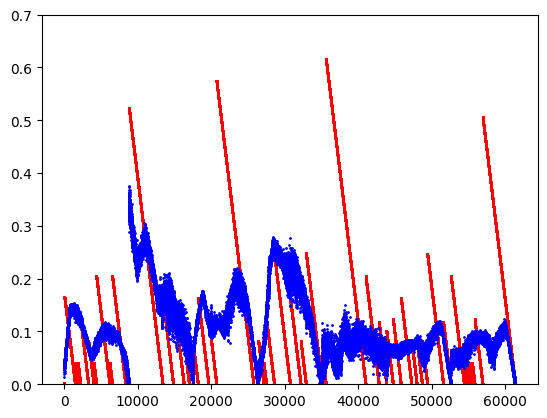

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Add
#Data transfer
train_data = X_train  
train_labels = y_train 
test_data = X_test
test_labels = y_test

# Define the input layer
input_layer = Input(shape=(None, 6))

# Define the LSTM layer with skip connection
lstm_layer = LSTM(6, activation='relu', return_sequences=True)(input_layer)
skip_layer = Add()([input_layer, lstm_layer]) #concatenate([input_layer, lstm_layer])

# Define the output layer
output_layer = LSTM(64, activation='relu')(skip_layer)
output_layer = Dense(1)(output_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Reshape the data for compatibility with RNN input shape
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=32)

# Evaluate the model
# mse = model.evaluate(test_data, test_labels)
# print(f"Mean Squared Error: {mse}")

# Make predictions
# predictions = model.predict(test_data)

mse = model.evaluate(test_data, test_labels)
print(f"Mean Squared Error: {mse}")

# Make predictions
predict = model.predict(test_data)
print_plot(y_test, predict)

In [46]:
#Stacked LSTM

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Data transfer
train_data = X_train  
train_labels = y_train 
test_data = X_test
test_labels = y_test

# Create the stacked LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(None, 6)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))  # Output layer with a single neuron for forecasting

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Reshape the data for compatibility with LSTM input shape
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=32)

# # Evaluate the model
# mse = model.evaluate(test_data, test_labels)
# print(f"Mean Squared Error: {mse}")

# # Make predictions
# predictions = model.predict(test_data)


Epoch 1/10
7667/7667 [==============================] - 7s 828us/step - loss: 0.0158
Epoch 2/10
7667/7667 [==============================] - 6s 827us/step - loss: 0.0141
Epoch 3/10
7667/7667 [==============================] - 6s 818us/step - loss: 0.0136
Epoch 4/10
7667/7667 [==============================] - 6s 832us/step - loss: 0.0134
Epoch 5/10
7667/7667 [==============================] - 7s 863us/step - loss: 0.0132
Epoch 6/10
7667/7667 [==============================] - 6s 844us/step - loss: 0.0129
Epoch 7/10
7667/7667 [==============================] - 7s 899us/step - loss: 0.0127
Epoch 8/10
7667/7667 [==============================] - 7s 856us/step - loss: 0.0126
Epoch 9/10
7667/7667 [==============================] - 7s 869us/step - loss: 0.0125
Epoch 10/10
7667/7667 [==============================] - 7s 848us/step - loss: 0.0124


1917/1917 [==============================] - 1s 335us/step - loss: 0.0235
Mean Squared Error: 0.023451952263712883
1917/1917 [==============================] - 1s 319us/step
MAE:0.10558594174828763
MSE:0.0234519347101225


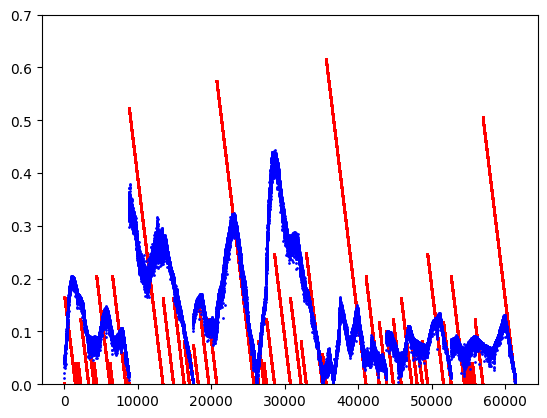

In [48]:

mse = model.evaluate(test_data, test_labels)
print(f"Mean Squared Error: {mse}")

# Make predictions
predict = model.predict(test_data)
print_plot(y_test, predict)


In [49]:
## CNN model 

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

def create_cnn_model(input_shape):
    model = Sequential()

    # Convolutional layer
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # Max pooling layer
    model.add(MaxPooling1D(pool_size=2))
    
    # Flatten the output
    model.add(Flatten())
    
    # Dense (fully connected) layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output layer (1 node for regression)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [51]:
##### import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Reshape the input data to fit the CNN model
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Create the CNN model
input_shape = X_train.shape[1:]
model = create_cnn_model(input_shape)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# # Evaluate the model on the test set
# loss = model.evaluate(X_test, y_test)
# print("Test Loss:", loss)


Epoch 1/10
7667/7667 [==============================] - 2s 305us/step - loss: 0.0163
Epoch 2/10
7667/7667 [==============================] - 2s 318us/step - loss: 0.0149
Epoch 3/10
7667/7667 [==============================] - 2s 315us/step - loss: 0.0145
Epoch 4/10
7667/7667 [==============================] - 2s 303us/step - loss: 0.0142
Epoch 5/10
7667/7667 [==============================] - 2s 313us/step - loss: 0.0140
Epoch 6/10
7667/7667 [==============================] - 2s 311us/step - loss: 0.0138
Epoch 7/10
7667/7667 [==============================] - 2s 317us/step - loss: 0.0137
Epoch 8/10
7667/7667 [==============================] - 2s 319us/step - loss: 0.0136
Epoch 9/10
7667/7667 [==============================] - 2s 318us/step - loss: 0.0135
Epoch 10/10
7667/7667 [==============================] - 3s 350us/step - loss: 0.0134


1917/1917 [==============================] - 0s 208us/step
MAE:0.10373996827765179
MSE:0.021236534663290316


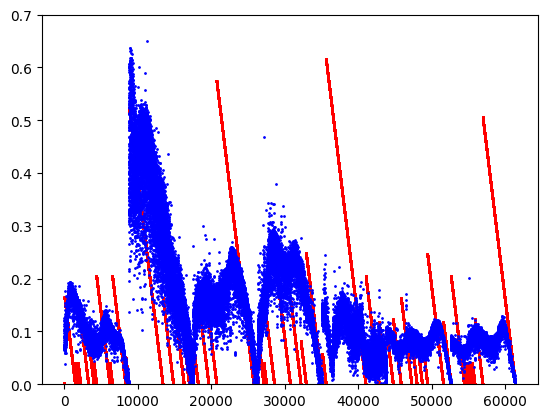

In [52]:
# Make predictions
predict = model.predict(X_test)
print_plot(y_test, predict)

In [53]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4353 (17.00 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [54]:
# Resnet replica on 1D tabular dataset

In [55]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Add
Input_layer = Input(shape=input_shape)
x = Conv1D(filters=32, kernel_size=3, padding = 'same', activation='relu', input_shape=input_shape)(Input_layer)
x = Conv1D(filters=32, kernel_size=3, padding = 'same', activation='relu')(x)
y = Add()([x, Input_layer])
temp = x
x = Conv1D(filters=32, kernel_size=3, padding = 'same', activation='relu')(y)
z = Add()([x, temp])
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)  # Output layer (1 node for regression)

In [56]:
model = Model(inputs=Input_layer, outputs=x)

In [57]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 6, 32)                128       ['input_2[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 6, 32)                3104      ['conv1d_1[0][0]']            
                                                                                                  
 add_1 (Add)                 (None, 6, 32)                0         ['conv1d_2[0][0]',            
                                                                     'input_2[0][0]']       

In [58]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# # Evaluate the model on the test set
# loss = model.evaluate(X_test, y_test)
# print("Test Loss:", loss)

Epoch 1/10
7667/7667 [==============================] - 6s 702us/step - loss: 0.0155
Epoch 2/10
7667/7667 [==============================] - 5s 653us/step - loss: 0.0135
Epoch 3/10
7667/7667 [==============================] - 5s 675us/step - loss: 0.0129
Epoch 4/10
7667/7667 [==============================] - 5s 650us/step - loss: 0.0128
Epoch 5/10
7667/7667 [==============================] - 5s 649us/step - loss: 0.0128
Epoch 6/10
7667/7667 [==============================] - 5s 689us/step - loss: 0.0126
Epoch 7/10
7667/7667 [==============================] - 6s 749us/step - loss: 0.0125
Epoch 8/10
7667/7667 [==============================] - 5s 678us/step - loss: 0.0126
Epoch 9/10
7667/7667 [==============================] - 5s 670us/step - loss: 0.0123
Epoch 10/10
7667/7667 [==============================] - 5s 650us/step - loss: 0.0123


1917/1917 [==============================] - 1s 298us/step
MAE:0.10461696376779064
MSE:0.021998547786103353


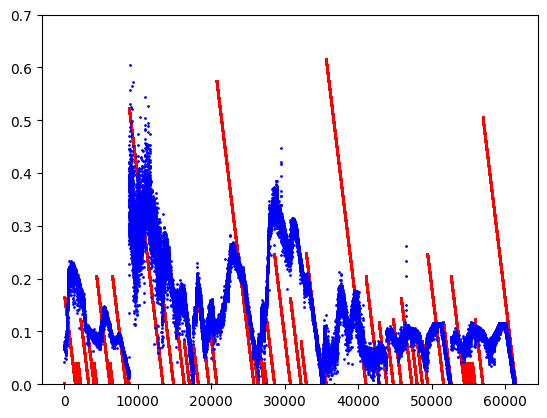

In [59]:
# Make predictions
predict = model.predict(X_test)
print_plot(y_test, predict)

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Generate some random tabular data for demonstration
train_data = X_train  
train_labels = y_train 
test_data = X_test
test_labels = y_test

# Create the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(None, 6)))
model.add(Dense(1))  # Output layer with a single neuron for forecasting

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Reshape the data for compatibility with LSTM input shape
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=32)


Epoch 1/10
7667/7667 [==============================] - 5s 581us/step - loss: 0.0167
Epoch 2/10
7667/7667 [==============================] - 4s 498us/step - loss: 0.0157
Epoch 3/10
7667/7667 [==============================] - 4s 521us/step - loss: 0.0152
Epoch 4/10
7667/7667 [==============================] - 4s 505us/step - loss: 0.0148
Epoch 5/10
7667/7667 [==============================] - 4s 480us/step - loss: 0.0146
Epoch 6/10
7667/7667 [==============================] - 4s 483us/step - loss: 0.0144
Epoch 7/10
7667/7667 [==============================] - 4s 493us/step - loss: 0.0143
Epoch 8/10
7667/7667 [==============================] - 4s 493us/step - loss: 0.0142
Epoch 9/10
7667/7667 [==============================] - 4s 478us/step - loss: 0.0142
Epoch 10/10
7667/7667 [==============================] - 4s 474us/step - loss: 0.0141


1917/1917 [==============================] - 1s 264us/step - loss: 0.0202
Mean Squared Error: 0.02019675262272358
1917/1917 [==============================] - 1s 239us/step
MAE:0.10601716756343198
MSE:0.02019676281963734


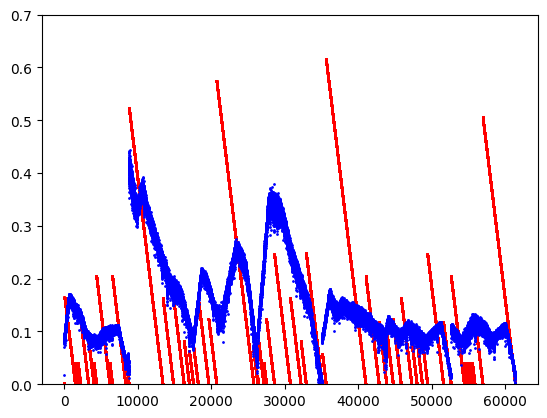

In [61]:
# Evaluate the model
mse = model.evaluate(test_data, test_labels)
print(f"Mean Squared Error: {mse}")

# Make predictions
predict = model.predict(test_data)
print_plot(y_test, predict)

In [62]:
from tensorflow.keras.layers import Reshape

train_data = X_train  
train_labels = y_train 
test_data = X_test
test_labels = y_test

# Create the CNN+LSTM hybrid model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Reshape((1, 64)))  # Reshape output of Flatten layer to (batch_size, 1, 64)
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))  # Output layer with a single neuron for forecasting

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Reshape the data for compatibility with CNN+LSTM input shape
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=32)

Epoch 1/10
7667/7667 [==============================] - 5s 637us/step - loss: 0.0159
Epoch 2/10
7667/7667 [==============================] - 5s 639us/step - loss: 0.0147
Epoch 3/10
7667/7667 [==============================] - 5s 647us/step - loss: 0.0141
Epoch 4/10
7667/7667 [==============================] - 5s 652us/step - loss: 0.0137
Epoch 5/10
7667/7667 [==============================] - 5s 654us/step - loss: 0.0135
Epoch 6/10
7667/7667 [==============================] - 5s 656us/step - loss: 0.0133
Epoch 7/10
7667/7667 [==============================] - 5s 658us/step - loss: 0.0132
Epoch 8/10
7667/7667 [==============================] - 5s 702us/step - loss: 0.0130
Epoch 9/10
7667/7667 [==============================] - 5s 670us/step - loss: 0.0129
Epoch 10/10
7667/7667 [==============================] - 5s 674us/step - loss: 0.0129


1917/1917 [==============================] - 1s 319us/step - loss: 0.0199
Mean Squared Error: 0.01987561397254467
1917/1917 [==============================] - 1s 286us/step
MAE:0.09584584796843916
MSE:0.019875623394714697


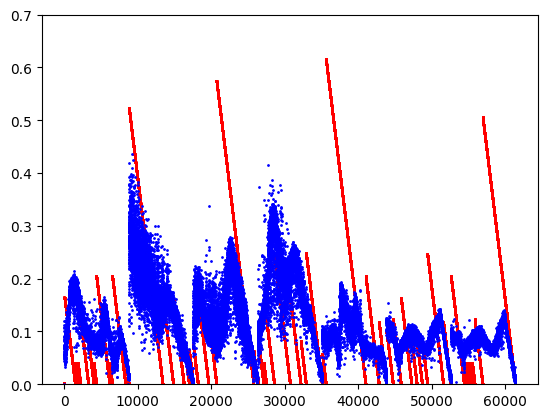

In [63]:
# Evaluate the model
mse = model.evaluate(test_data, test_labels)
print(f"Mean Squared Error: {mse}")

# Make predictions
predict = model.predict(test_data)
print_plot(y_test, predict)

In [64]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)